In [350]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import bipartite
import itertools 
# %matplotlib notebook

In [368]:
# Import initial network
data = pd.read_excel('data_test.xlsx')
data = data.head(100)
# Creating a bipartite graph
B = nx.from_pandas_edgelist(data, source='StockCode',  target='InvoiceNo', edge_attr='Quantity')
# Check bipartite (if needed)
print(bipartite.is_bipartite(B))
# Generate projected graph G
I = set(data['StockCode'])
G = bipartite.weighted_projected_graph(B,I)
# # Check network connectivity 
# print(nx.is_connected(G))
# # Count connected components (if required)
# print(nx.number_connected_components(G))
# # Using Girvan–Newman built-in method of GraphX
# comp = girvan_newman(G)
# li = list(comp)
# len(li)

True


<IPython.core.display.Javascript object>


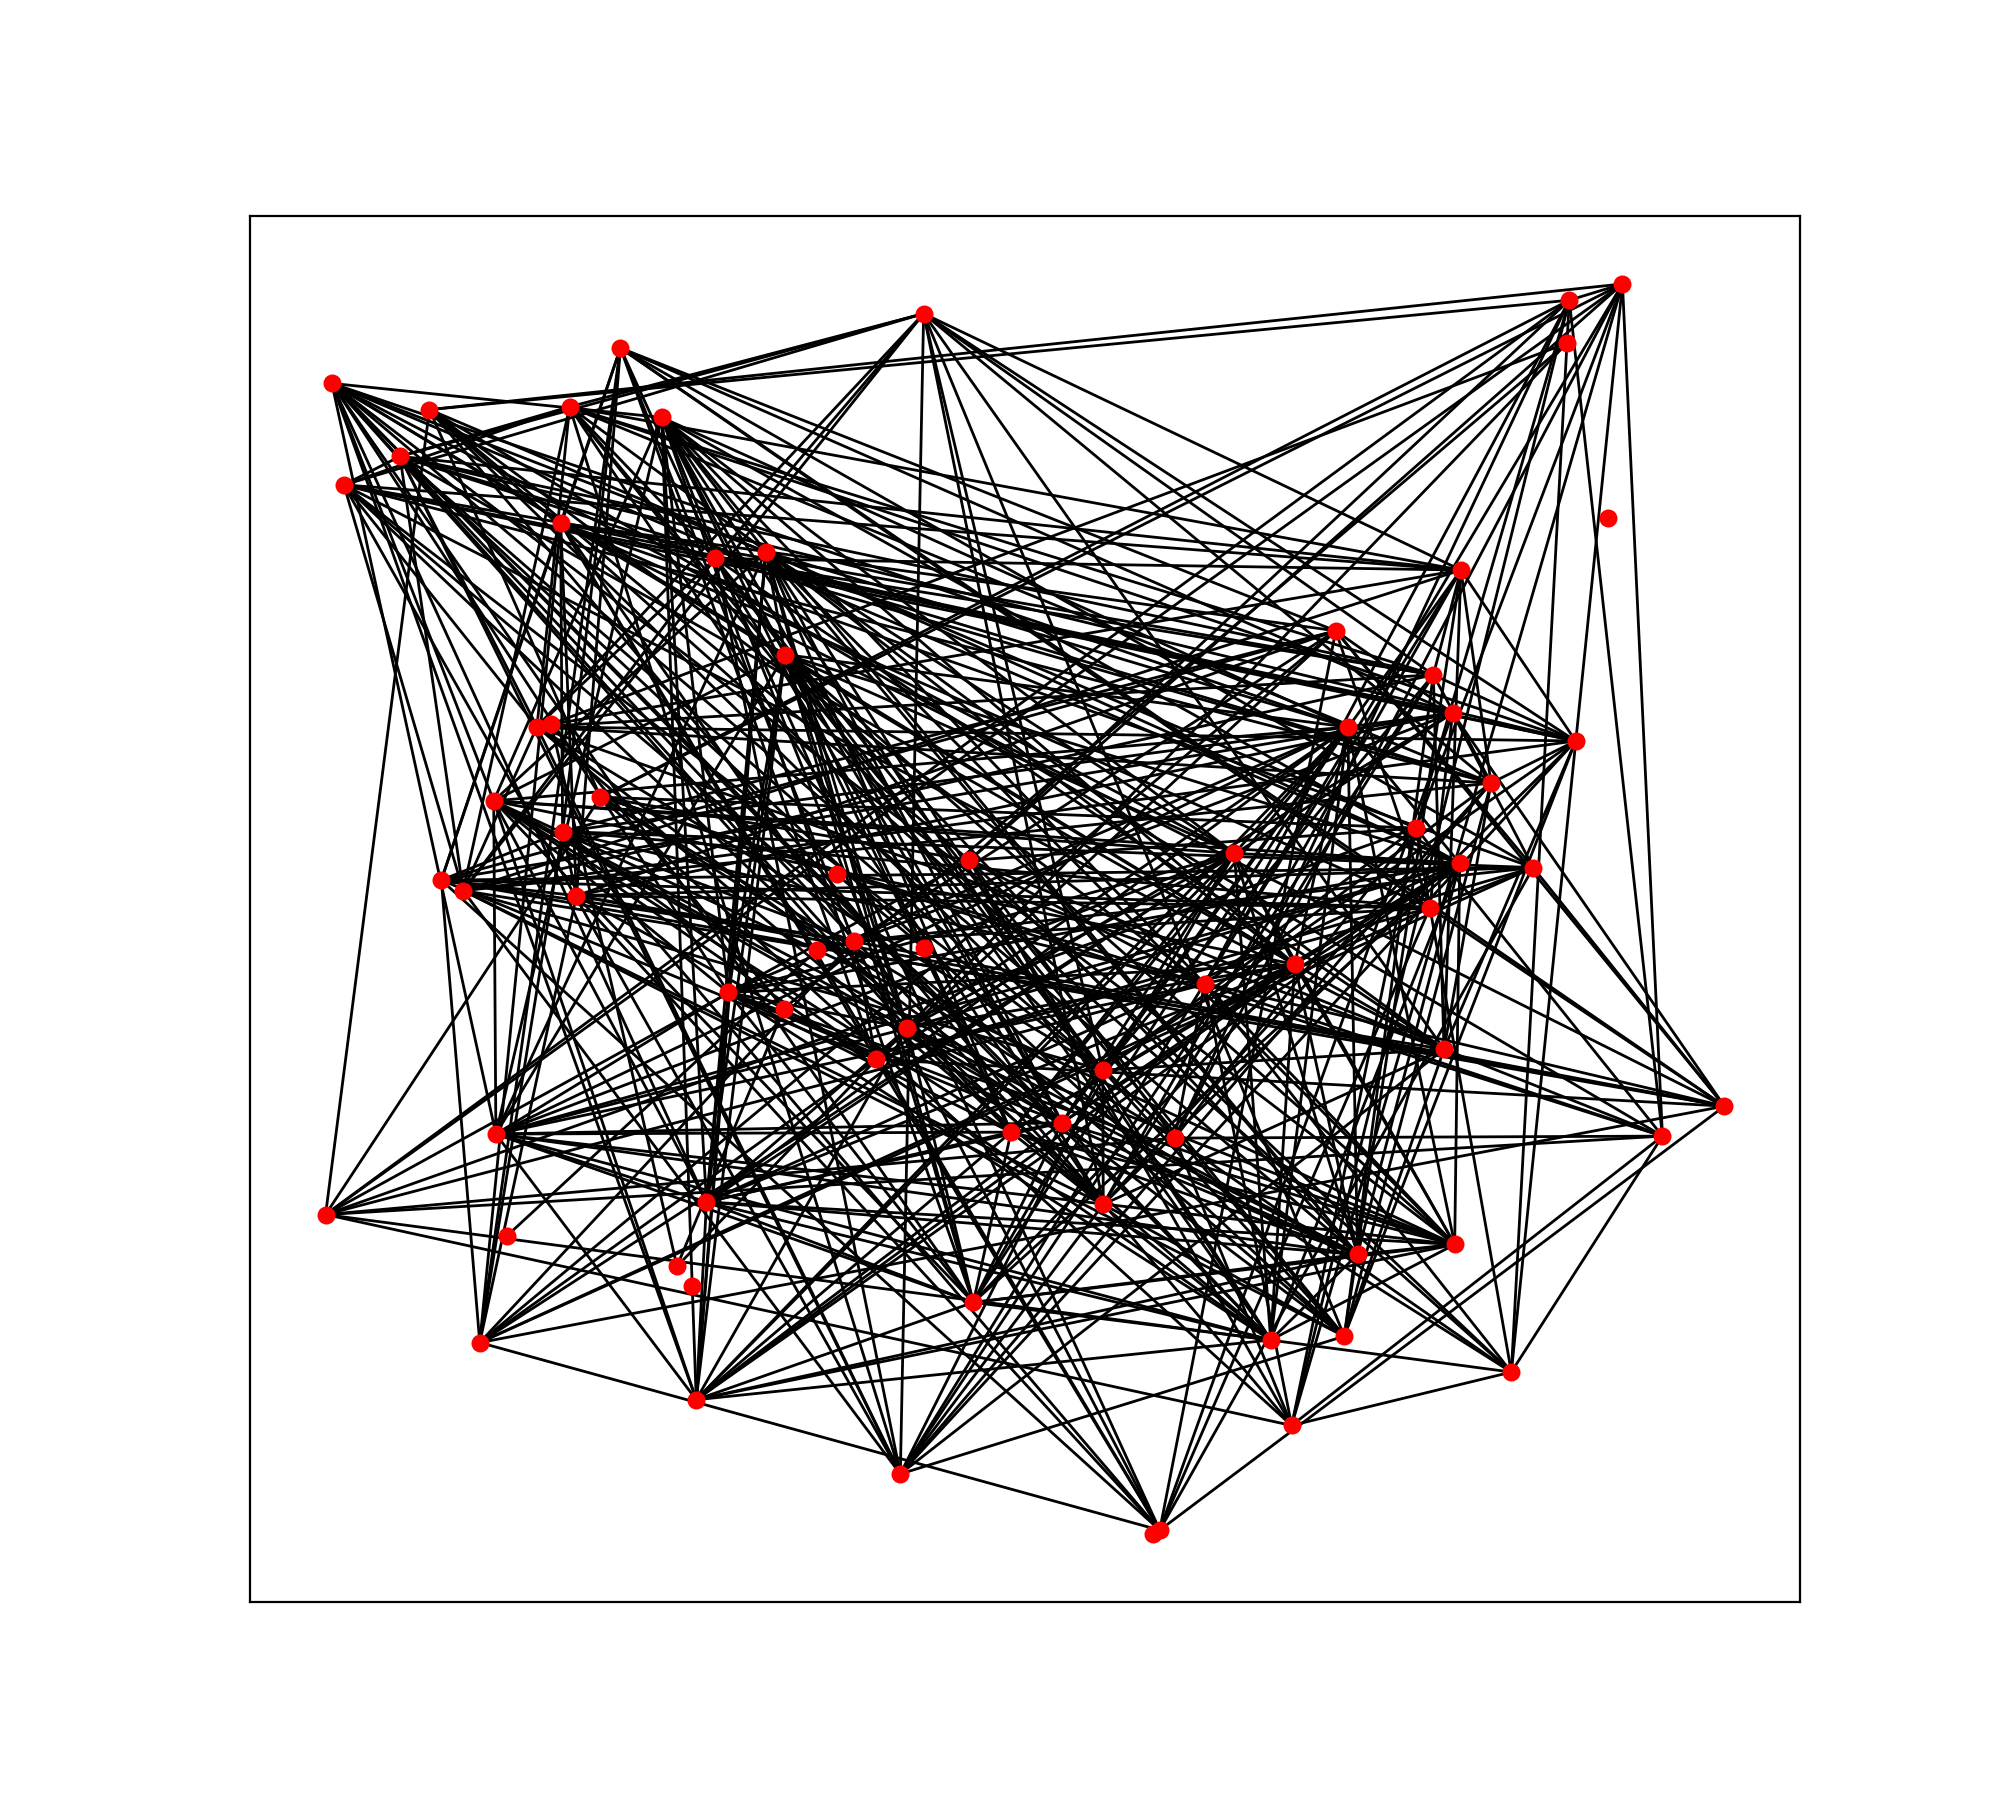

In [352]:
# Draw the projected graph using the random layout
plt.figure(figsize=(10,9))
pos = nx.random_layout(G)
nx.draw_networkx(G, pos, with_labels=False, node_size=30, font_size=5, node_color='red')

In [370]:
def update_degree(adj_matrix, node_list):
    '''
    Update node degree after each iteration:
    adj_matrix is the new adj_matrix of G - nx.adj_matrix(G)
    node_list array contains nodes of G that will be updated - G.nodes()
    
    '''
    deg_dict = {}
    n = adj_matrix.shape[0]
    new_deg = adj_matrix.sum(axis = 1)
    i = 0
    for idx in list(node_list):
        deg_dict[idx] = new_deg[i, 0]
        i += 1
    return deg_dict

In [371]:
def get_modularity(G, o_deg_dict, m):
    '''
    Calculate modularity Q of the decomposed graph G:
    variables with "o_" prefix represents "original_"
    variables with "n_" prefix represents "new_"
    e_ii: the fraction of edges in the network that connect vertices in the same community 
    a_i: the fraction of edges that connect TO vertices in community i
    (Newman and Girvan, 2004)
    
    '''
    n_adj_matrix = nx.adj_matrix(G)
    n_deg_dict = update_degree(n_adj_matrix, G.nodes())
    # Compute modularity Q:
    print('Number of communities after split: {}'.format(nx.number_connected_components(G)))
    comp_list = nx.connected_components(G)
    Q = 0
    for comp in comp_list:
        e_ii = 0
        a_i = 0
        for node in comp:
            e_ii += n_deg_dict[node]
            a_i += o_deg_dict[node]
        Q += (float(e_ii)/(2*m) - float(a_i*a_i)/(4*m*m) )
    print('Modularity of this decomposed graph G: {}'.format(Q))
    return Q

In [372]:
def find_edge(G):
    '''
    Finding node having the largest edge betweeness after each iteration (partition)
    '''
    edge_values = nx.edge_betweenness_centrality(G)
    edge_to_remove = sorted(edge_values.items(), key = lambda x: x[1], reverse = True)
    return edge_to_remove[0][0]

def newman_girvan(G):
    '''
    Divisive community detection process
    '''
    # Original number of edges in graph G:
    m = len(G.edges())
    # Original adj_matrix of graph G:
    o_adj_matrix = nx.adj_matrix(G)
    o_deg_dict = update_degree(o_adj_matrix, G.nodes())
    # Remove edge with highest edge betweeeness
    init_comp = nx.connected_component_subgraphs(G)
    init_ncomp = nx.number_connected_components(G)
    print('Init: {} connected components'.format(init_ncomp))
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        G.remove_edge(*find_edge(G))
        comp = nx.connected_component_subgraphs(G)
        ncomp = nx.number_connected_components(G)
    print('End: {} connected components'.format(ncomp))
    Q = get_modularity(G, o_deg_dict, m)
    subgraphs = list(nx.connected_component_subgraphs(G))
    print('*'*30)
    return subgraphs, Q

In [385]:
def find_optimalQ(G):
    G_clone = G.copy()
    comps = {}
    while True:
        subgraphs, Q = newman_girvan(G_clone)
        comps[Q] = subgraphs
        if G_clone.number_of_edges() ==0:
            print('No more edge to remove. End splitting!')
            break
    return comps

In [381]:
comps = find_optimalQ(G)

Init: 10 connected components
End: 11 connected components
Number of communities after split: 11
Modularity of this decomposed graph G: 0.7766626038781163
******************************
Init: 11 connected components
End: 12 connected components
Number of communities after split: 12
Modularity of this decomposed graph G: 0.7741265081873024
******************************
Init: 12 connected components
End: 13 connected components
Number of communities after split: 13
Modularity of this decomposed graph G: 0.7730715255771843
******************************
Init: 13 connected components
End: 14 connected components
Number of communities after split: 14
Modularity of this decomposed graph G: 0.748671355376635
******************************
Init: 14 connected components
End: 15 connected components
Number of communities after split: 15
Modularity of this decomposed graph G: 0.7489234567901234
******************************
Init: 15 connected components
End: 16 connected components
Number of co

******************************
Init: 68 connected components
End: 69 connected components
Number of communities after split: 69
Modularity of this decomposed graph G: 0.265625
******************************
Init: 69 connected components
End: 70 connected components
Number of communities after split: 70
Modularity of this decomposed graph G: 0.09183673469387751
******************************
Init: 70 connected components
End: 71 connected components
Number of communities after split: 71
Modularity of this decomposed graph G: 0.125
******************************
Init: 71 connected components
End: 72 connected components
Number of communities after split: 72
Modularity of this decomposed graph G: 0.125
******************************
Init: 72 connected components
End: 73 connected components
Number of communities after split: 73
Modularity of this decomposed graph G: -0.5
******************************
No more edges to remove. End splitting!


In [384]:
max(comps.keys())

0.8062795305593659

In [ ]:
for comp in subgraphs:
    print(comp.nodes())
    print('*'*10)